Adaptive Mesh Refinement
----
***

In [2]:
import numpy as np
import time
MAX_REFINE_LIMIT = 8
MIN_REFINE_LIMIT = 4
DIRECTIONS = np.ones((4,2))
DIRECTIONS[1][1] *=-1
DIRECTIONS[2] *=-1
DIRECTIONS[3][0] *=-1 
print(DIRECTIONS)


# TODO:
# error tolerance at each level
# for each mesh points mp in partition p { if errorEstimate(mp) > tol) {
# mark mp for refinement;
# } }
# refine mesh structure where marked;

# Error estimate:

def lerp(u1, u2, x1, x2, x_new):
    return u1 + (u2 - u1) * (x_new - x1) / (x2 - x1)

class QuadTree:
    def __init__(self) -> None:
        self.root = None

class CellCenteredNode:
    def __init__(self, pos:np.ndarray, size:np.ndarray, depth:int=0, pressure:float=None, velocity:list=None, parent=None) -> None:
        self.pos = pos
        self.size = size
        self.depth = depth
        self.pressure = pressure
        self.velocity = velocity

        # TODO maybe change this to [None, None, None, None] 
        self.child_nodes = []
        self.parent = None
    
    # TODO check efficiency of this rather than just checking depth each time
    def is_leaf(self):
        return len(self.child_nodes) == 0
    
    def is_root(self):
        return not self.parent
        """if self.parent is None:
            return True
        return False"""
    
    def subdivide(self):
        if self.is_leaf():
            subsize = self.size/2
            # TODO change the uniform distribution of cell data to a method that is based off of the gradient and neighbors
            # TODO Initially each child node inherits values of interest from parent. I want to interpolate them later
            self.child_nodes = [CellCenteredNode(new_loc, subsize, self.depth + 1, self.pressure, self.velocity, self) for new_loc in (subsize * DIRECTIONS + self.pos)]
        return
    
    def can_coarsen(self):
        # TODO make better and implement check
        if self.depth > MIN_REFINE_LIMIT:
            if not self.is_leaf():
                # TODO check here:
                # ex: if child nodes all meet refinement criteria (gradient not steep, not on cylinder border), 
                # then remove all child_nodes and ???interpolate (may or may not need to depending on how data is stored)
                for child in self.child_nodes:
                    pass
                return
        return

    def coarsen(self):
        self.child_nodes = []

# TODO --------------------------------------------------------------------------------------> vvv Adjust based on radius of circle
def intersects_cylinder(node:CellCenteredNode, cylinder_center:np.ndarray, cylinder_radius, threshold=0.33):    
    node_corners = node.size * DIRECTIONS + node.pos

    if -0.1 <= ((node.pos[0] - cylinder_center[0])**2 + (node.pos[1] - cylinder_center[1])**2) ** 0.5-cylinder_radius <= threshold:
        return True
    for corner in node_corners:
        if -0.1 <= ((corner[0] - cylinder_center[0])**2 + (corner[1] - cylinder_center[1])**2) ** 0.5-cylinder_radius <= threshold:
            return True
    return False

def is_on_cylinder_boundary(node:CellCenteredNode, cylinder_center:np.ndarray, cylinder_radius:float, threshold = 0.02):
    #if -threshold <= ((node.pos[0] - cylinder_center[0])**2 + (node.pos[1] - cylinder_center[1])**2) ** 0.5-cylinder_radius < threshold:
        #return True
    #return False
    return -threshold <= ((node.pos[0] - cylinder_center[0])**2 + (node.pos[1] - cylinder_center[1])**2) ** 0.5-cylinder_radius < threshold
    

def is_inside_cylinder(node:CellCenteredNode, cylinder_center, cylinder_radius, threshold = -0.02):
    return ((node.pos[0] - cylinder_center[0])**2 + (node.pos[1] - cylinder_center[1])**2) ** 0.5-cylinder_radius <= threshold



def initialize_coarse_grid(root:CellCenteredNode, base_refinement = MIN_REFINE_LIMIT):
    if root.depth < base_refinement:
        root.subdivide()
        for child in root.child_nodes:
            initialize_coarse_grid(child, base_refinement)
    return root

def add_cylinder(root:CellCenteredNode, cylinder_center:np.ndarray, cylinder_radius:float, refinement_limit=MAX_REFINE_LIMIT):    
    border_cells = []
    def refine_cylinder(root:CellCenteredNode, cylinder_center:np.ndarray, cylinder_radius:float, refinement_limit=MAX_REFINE_LIMIT):
        nonlocal border_cells
        if root.depth >= refinement_limit:
            """if intersects_cylinder(root, cylinder_center, cylinder_radius):
                border_cells.append(root)"""
            return
        if intersects_cylinder(root, cylinder_center, cylinder_radius):
            root.subdivide()
            border_cells.extend(root.child_nodes)
        for child in root.child_nodes:
            refine_cylinder(child, cylinder_center, cylinder_radius, refinement_limit)
    
    refine_cylinder(root, cylinder_center, cylinder_radius, refinement_limit)
    return border_cells



def get_cylinder_boundaries(node_list:list, cylinder_center:np.ndarray, cylinder_radius:float):
    border_cells = []
    for node in node_list:
        if is_on_cylinder_boundary(node, cylinder_center, cylinder_radius):
            border_cells.append(node)
    return border_cells

def coarsen_quadtree(quadtree:CellCenteredNode, coarsening_region):
    def should_coarsen(cell:CellCenteredNode):
        if cell.parent is None:
            return False  # Can't coarsen the root
        siblings_and_self = cell.parent.children
        return all(coarsening_region(s.center, s.size) for s in siblings_and_self)
    
    def coarsen_cell(cell:CellCenteredNode):
        parent = cell.parent
        if parent is not None and should_coarsen(cell):
            for child in parent.children:
                # Here, you might average or interpolate the child cells' values to the parent
                pass
            parent.children = []  # Remove children, effectively coarsening the mesh
            
    # Traverse the quadtree to apply coarsening
    def traverse_and_coarsen(cell:CellCenteredNode):
        if cell.is_leaf():
            coarsen_cell(cell)
        else:
            for child in cell.children:
                traverse_and_coarsen(child)
                
    traverse_and_coarsen(quadtree)


class Mesh:
    def __init__(self, root:CellCenteredNode, domain_size:np.ndarray, refinement_limit=MAX_REFINE_LIMIT) -> None:
        self.root = root
        self.refinement_limit=refinement_limit
        self.base_refinement = MIN_REFINE_LIMIT
        self.domain_size = domain_size
        self.border_cells = {'left':[],
                             'right':[],
                             'top':[],
                             'bottom':[]}

    def init_geometry(self, cylinder_center, cylinder_radius):
        self.cylinder_center = cylinder_center
        self.cylinder_radius = cylinder_radius

    def init_coarse_grid(self):
        def recurse_coarse_grid(root:CellCenteredNode):
            if root.depth < self.base_refinement:
                root.subdivide()
                for child in root.child_nodes:
                    recurse_coarse_grid(child)

        recurse_coarse_grid(self.root)
        return self.root

    def add_cylinder(self):    
        #border_cells = []
        self.cylinder_cells = []
        def refine_cylinder(root:CellCenteredNode):
            #nonlocal border_cells
            if root.depth >= self.refinement_limit:
                """if intersects_cylinder(root, cylinder_center, cylinder_radius):
                    border_cells.append(root)"""
                return
            if intersects_cylinder(root, self.cylinder_center, self.cylinder_radius):
                root.subdivide()
                self.cylinder_cells.extend(root.child_nodes)
            for child in root.child_nodes:
                refine_cylinder(child)
        
        refine_cylinder(self.root)
        return self.cylinder_cells
    
    def get_cylinder_boundaries(self, node_list:list[CellCenteredNode]):
        self.cylinder_edge = []
        for node in node_list:
            if is_on_cylinder_boundary(node, self.cylinder_center, self.cylinder_radius):
                self.cylinder_edge.append(node)
                node.velocity = np.array([0,0])
                # TODO set node pressure
                # node.pressure = normal gradient
        return self.cylinder_edge
    
    def remove_inner_cells(self):
        outside_cells = []
        for node in self.cylinder_cells:
            if not is_inside_cylinder(node, self.cylinder_center, self.cylinder_radius):
                outside_cells.append(node)
        self.cylinder_cells = outside_cells
        return outside_cells


    def get_border_nodes(self):
        self.border_cells = {'left':[],
                             'right':[],
                             'top':[],
                             'bottom':[]}
        def traverse_count(root:CellCenteredNode):
            if root.is_leaf():
                return
            #if any(root.pos + root.size) == self.domain_size[0]:
            
        traverse_count(self.root)
        return

    



[[ 1.  1.]
 [ 1. -1.]
 [-1. -1.]
 [-1.  1.]]


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_quad_tree(root:CellCenteredNode, cylinder_center, cylinder_radius):
    fig, ax = plt.subplots()
    
    ax.set_aspect('equal')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    def plot_node(node:CellCenteredNode):
        if node.is_leaf():
            #print(f"I AM LEAF {node.depth}")
            #print(node.pos[0] - node.size[0], node.pos[1] - node.size[1])
            rect = patches.Rectangle((node.pos[0] - node.size[0], node.pos[1] - node.size[1]), 
                                     2*node.size[0], 2*node.size[1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        else:
            for child in node.child_nodes:
                # print(child)
                plot_node(child)
    
    plot_node(root)
    circle1 = plt.Circle(cylinder_center, cylinder_radius, color='b', fill=False)
    ax.add_patch(circle1)
    plt.show()

0.019273042678833008
0.08197808265686035


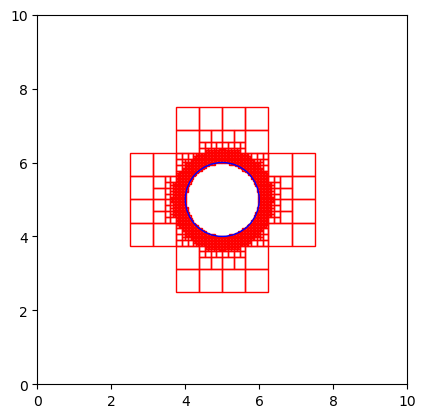

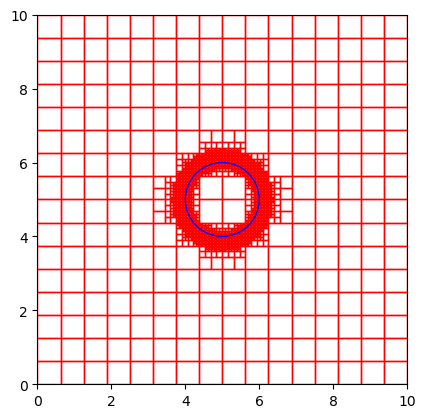

'\n0.023892879486083984\n0.02008819580078125\n0.021297931671142578\n0.07841300964355469\n0.016726016998291016\n0.014898300170898438\n0.017200946807861328\n0.015385150909423828\n0.0180511474609375\n0.014584064483642578\n'

In [4]:
# Parameters for the domain and cylinder
domain_width = 10
domain_height = 10
cylinder_center = np.array([5, 5])  # Assuming the cylinder is at the center
cylinder_radius = 1.0
max_depth = 3  # Maximum depth for initial refinement

# Create the root node representing the entire domain
root = CellCenteredNode(np.array([5,5]), np.array([5,5]))
root2 = CellCenteredNode(np.array([5,5]), np.array([5,5]))

# Build the initial coars mesh
start = time.time()
initialize_coarse_grid(root)
border_nodes = add_cylinder(root, cylinder_center, cylinder_radius)
print(time.time()-start)
border_nodes = get_cylinder_boundaries(border_nodes, cylinder_center, cylinder_radius)


start = time.time()
mesh = Mesh(root2, [domain_width, domain_height])
mesh.init_geometry(cylinder_center, cylinder_radius)
mesh.init_coarse_grid()
border_nodes = mesh.add_cylinder()
print(time.time()-start)
border_nodes = mesh.get_cylinder_boundaries(border_nodes)
border_nodes = mesh.remove_inner_cells()


fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
for node in border_nodes:
    if node.is_leaf():
        rect = patches.Rectangle((node.pos[0] - node.size[0], node.pos[1] - node.size[1]), 
                                     2*node.size[0], 2*node.size[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

circle1 = plt.Circle(cylinder_center, cylinder_radius, color='b', fill=False)
ax.add_patch(circle1)
plt.show()
# Visualize the initial mesh
visualize_quad_tree(root, cylinder_center, cylinder_radius)
#visualize_quad_tree(root2)
